In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir + '/pinns'), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

We are going to solve Damped Harmonic Oscillator problem using Kolmogorov-Arnold Network. Our setting will be the same as in default DHO solution method. As you will see, it differs not that much from FF training (thanks to authors of pykan for their effort in providing KAN as pytorch module).

Our library provides easy-to-use wrapper for pykan library, but you always kan define your own network.

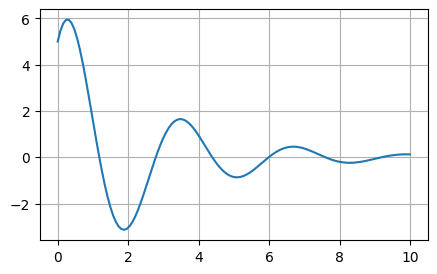

In [3]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

def dho(t, y, zeta, omega):
    x, v = y
    dxdt = v
    dvdt = -2 * zeta * omega * v - omega**2 * x
    return [dxdt, dvdt]

T = 10              # We need to fix some computational domain.
p = (0.2, 2.0)      # Parameters that yields interesting function.
x0, v0 = 5.0, 7.0   # Initial values may be arbitrary.

t = torch.linspace(0, T, 128)
solution = solve_ivp(dho, (0, T), (x0, v0), t_eval=t, args=p).y[0]

fig = plt.figure(figsize=(5, 3))
plt.plot(t, solution)
plt.grid()
plt.show()

In [4]:
from pinns.samplers import ConstantSampler, RandomSampler

# Constraints (training data) sampler must return tuple (points, values).
constraints_sampler = ConstantSampler((
    torch.tensor([[0.]], requires_grad=True),
    torch.tensor([x0, v0])
))

# Collocation sampler must return just tensor of shape [num_pts, coords].
domain_range = [0, T]
collocation_sampler = RandomSampler(domain_range, (256, 1))

# Test points sampler must return tuple (points, values) of shape [num_pts, coords].
test_points_sampler = ConstantSampler(
    (t.reshape(-1, 1), solution.reshape(-1, 1))
    )

In [5]:
from pinns.derivatives import d

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    zeta = 0.2, omega = 2.0
    ):
    
    def init_loss(x0, t0):
        v0 = d(x0, t0)
        return torch.mean(torch.square(torch.hstack([x0, v0]) - cstr_vals))

    def ode_loss(x, t):
        v = d(x, t)
        a = d(v, t)
        return torch.mean(torch.square(a + 2 * zeta * omega * v + omega**2 * x))
    
    losses = (
        init_loss(cstr_pred, cstr_pts),
        ode_loss(coll_pred, coll_pts)
    )
    
    return losses

In [7]:
from pinns import Trainer
from pinns.models import KAN
from pinns.optimizers import Adam

pinn = KAN([1, 5, 1], grid = 5)
print(f'Model has {pinn.count_parameters()} trainable parameters.')

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2],    # Coefficients are very important.
    test_points_sampler=test_points_sampler
)

# We employ grid refining method, as described in pykan: at some point we
# change number of grid points and continue training of the same model.
# Interestingly, this method works not as for classic regression problems
# (due to the peculiarities of PINNs training), but as described in our
# paper it somewhat helps to decrease approximation error.

# (how much iters, grid size)
itgrid = [(100, 2), (150, 5)]

for i, (it, grid) in enumerate(itgrid):
    
    pts, _ = test_points_sampler()

    pinn = KAN([1, 5, 1], grid = grid).initialize_from_another_model(trainer.model, pts)
    trainer.model = pinn
        
    adam = Adam(pinn, lr = 1e-2)
    
    # trainer.iter += 1
    trainer.train(
        num_iters = it,
        optimizers=[(0, adam)],
        validate_every=1,
        show_progress=True
    )

Model has 146 trainable parameters.


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/150 [00:00<?, ?it/s]

In [8]:
from pinns.errors import l2_error
print(f'L2 error of model is {trainer.evaluate(l2_error):.5f}')

L2 error of model is 3.66153


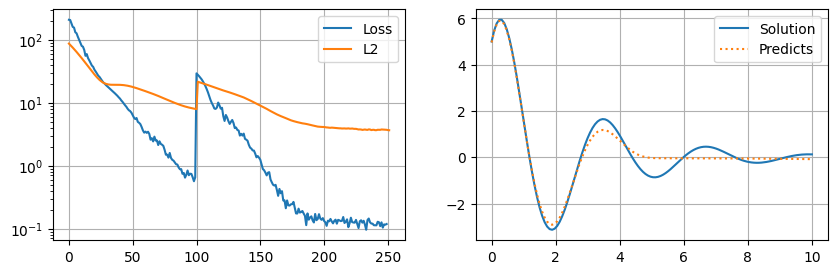

In [10]:
# pinn.model = torch.load('./very_good_model_dont_delete.pt')

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(trainer.loss_history, label='Loss')
axs[0].plot(trainer.error_history, label='L2')
axs[0].grid()
axs[0].set_yscale('log')
axs[0].legend()

preds = pinn.predict(t.reshape(-1, 1))
axs[1].plot(t, solution, label='Solution')
axs[1].plot(t, preds.detach(), label='Predicts', linestyle=':')
axs[1].grid()
axs[1].legend()

plt.show()

Despite bad approximation, we see that training is really works.

And we kan visualize activation functions of our trained network.

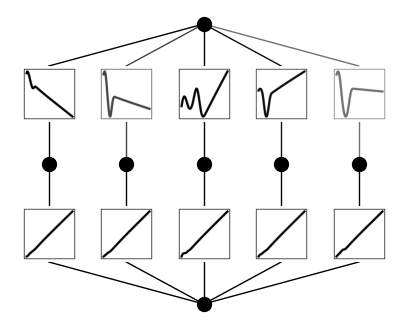

In [11]:
trainer.model.model.plot()